In [1]:
import pandas as pd
import torch
from transformers import *
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import time
import datetime

%matplotlib inline

In [2]:
reviews = pd.read_csv("Amazon_review_data/Reviews.csv")
reviews['ProductId']=reviews['ProductId'].astype(str)
df=reviews[reviews['ProductId']=="B007JFMH8M"]  ## the most popular cookie
df = df.reset_index(drop=True)
df= df[['Id', 'Text', 'Score']]
sentences=df.Text.values
labels= df.Score.values -1  ### here is important. because the BERT classification requires the label category start from 0
df.head()

,Id,Text,Score
0,562971,I love these cookies! Not only are they healt...,5
1,562972,Quaker Soft Baked Oatmeal Cookies with raisins...,5
2,562973,I am usually not a huge fan of oatmeal cookies...,5
3,562974,I participated in a product review that includ...,5
4,562975,My kids loved these. I was very pleased to giv...,5


In [3]:
sum(labels==1)
##binary classification if label is 5
bi_labels= 1*(labels==4)
sum(bi_labels==1)/len(bi_labels) ## 68% score 5

0.683461117196057

In [4]:
##load the bert model
model = BertModel.from_pretrained('bert-base-uncased') #cache_dir='some path that I want to download the model'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) #output_hidden_states=True, output_attentions=True
# input_ids = torch.tensor([tokenizer.encode("Let's see all hidden-states and attentions on this text")])
# input_ids

13


(array([804.,  90.,  10.,   5.,   2.,   1.,   0.,   0.,   0.,   1.]),
 array([  21. ,  122.6,  224.2,  325.8,  427.4,  529. ,  630.6,  732.2,
         833.8,  935.4, 1037. ]),
 <a list of 10 Patch objects>)

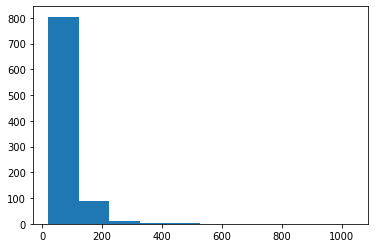

In [5]:
tokens_counts=[len(tokenizer.tokenize(sent)) for sent in sentences]
print(sum(np.array(tokens_counts)>256))
plt.hist(tokens_counts)  ## most texts is shorted than 400 tokens, we select 256 as the max_len of our sequence

In [6]:
input_token_ids=[]
for sent in sentences:
    input_token_ids.append(tokenizer.encode(sent,                         
                            max_length = 256))      # Truncate all sentences.
#                             return_tensors = 'pt'))     # Return pytorch tensors.

# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

## tokenize.encode can handle both two steps above, and then add special tokens [start] and [end]
print('Token IDs aftern encoding: ', tokenizer.encode(sentences[0]))

 Original:  I love these cookies!  Not only are they healthy but they taste great and are so soft!  I will definitely add these to my grocery list!
Tokenized:  ['i', 'love', 'these', 'cookies', '!', 'not', 'only', 'are', 'they', 'healthy', 'but', 'they', 'taste', 'great', 'and', 'are', 'so', 'soft', '!', 'i', 'will', 'definitely', 'add', 'these', 'to', 'my', 'grocery', 'list', '!']
Token IDs:  [1045, 2293, 2122, 16324, 999, 2025, 2069, 2024, 2027, 7965, 2021, 2027, 5510, 2307, 1998, 2024, 2061, 3730, 999, 1045, 2097, 5791, 5587, 2122, 2000, 2026, 13025, 2862, 999]
Token IDs aftern encoding:  [101, 1045, 2293, 2122, 16324, 999, 2025, 2069, 2024, 2027, 7965, 2021, 2027, 5510, 2307, 1998, 2024, 2061, 3730, 999, 1045, 2097, 5791, 5587, 2122, 2000, 2026, 13025, 2862, 999, 102]


In [7]:
## max length of the reviews:
print('Max sentence length: ', max([len(sen) for sen in input_token_ids]))
print('Min sentence length: ', min([len(sen) for sen in input_token_ids]))  ##padding has not been added

Max sentence length:  256
Min sentence length:  23


In [8]:
MAX_LEN = 256

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids=[]
for sent in input_token_ids:
    input_ids.append(F.pad(torch.tensor(sent, dtype=torch.long), (0, int(MAX_LEN-len(sent))), "constant", 0))
print('\nPadding added done')


Padding/truncating all sentences to 256 values...

Padding token: "[PAD]", ID: 0

Padding added done


In [9]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(torch.tensor(np.array(att_mask), dtype=torch.long))

In [10]:
# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, bi_labels, 
                                                            random_state=110, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=110, test_size=0.1)
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.stack(train_inputs)  ##convert a list of tensors into a tensor
validation_inputs = torch.stack(validation_inputs)

train_labels = torch.tensor(train_labels, dtype=torch.long) ## convert an array to a tensor
validation_labels = torch.tensor(validation_labels, dtype=torch.long)

train_masks = torch.stack(train_masks)
validation_masks = torch.stack(validation_masks)

In [11]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [12]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [13]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    hidden_dropout_prob= 0.05
)

# model.cuda() same thing
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [14]:
BertForSequenceClassification.from_pretrained??

In [15]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [16]:
from transformers import get_cosine_schedule_with_warmup
# transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5, last_epoch=-1)

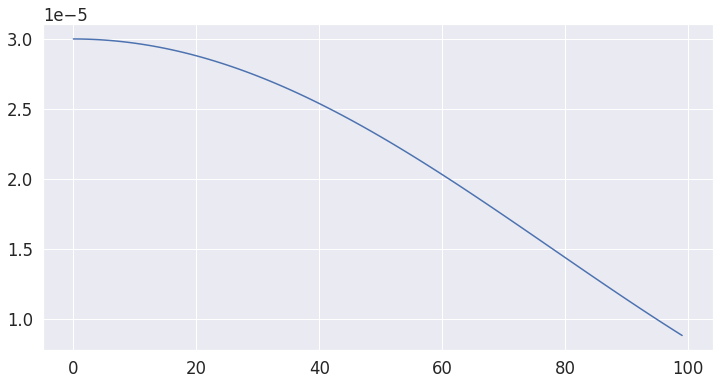

In [26]:
# For the purposes of fine-tuning, the authors recommend choosing from the following values:
# - Batch size: 16, 32  (We chose 32 when creating our DataLoaders).
# - Learning rate (Adam): 5e-5, 3e-5, 2e-5  (We'll use 2e-5).
# - Number of epochs: 2, 3, 4  (We'll use 4).
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
#'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 3e-5,  #9e-3, # args.learning_rate - default is 5e-5
                  eps =1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# from transformers import get_linear_schedule_with_warmup
from transformers import get_cosine_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# scheduler = get_cosine_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps = 0, # Default value in run_glue.py
#                                             num_training_steps = total_steps,
#                                             num_cycles=0.5, last_epoch=-1)

##continue to train the model with linear scheduler
scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps,
                                            num_cycles=0.5, last_epoch=-1)


##plot the lrs
lrs=[]
for i in range(100):
    lrs.append(scheduler.get_lr()) 
    scheduler.step()
plt.plot(range(100), lrs)

Below is the training and evaluation loop:

Training loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

So please read carefully through the comments to get an understanding of what's happening. If you're unfamiliar with pytorch a quick look at some of their [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) will help show you that training loops really involve only a few simple steps; the rest is usually just decoration and logging.  

In [18]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten() 
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [27]:
import random
## the training loop is based on
## https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
seed_val = 10

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 10 batches. (one epoch has 26 batches)
        if step % 10 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, ## this token type id only works for next sentence prediction
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0] # (loss), logits, (hidden_states), (attentions) 

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        
        total_loss += loss.item()


        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        print('sample validation')
        print(logits[0:3])
        print(label_ids[0:3])

        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch    10  of     52.    Elapsed: 0:00:14.
  Batch    20  of     52.    Elapsed: 0:00:27.
  Batch    30  of     52.    Elapsed: 0:00:41.
  Batch    40  of     52.    Elapsed: 0:00:54.
  Batch    50  of     52.    Elapsed: 0:01:08.

  Average training loss: 0.11
  Training epcoh took: 0:01:10

Running Validation...
sample validation
[[ 1.950382  -1.5081319]
 [-1.2723032  1.1741405]
 [-1.6116971  1.4516081]]
[1 1 1]
sample validation
[[-2.3668082  1.7919595]
 [-1.8207202  1.6401031]
 [ 2.8682592 -2.6678197]]
[1 1 0]
sample validation
[[-2.2498858  1.7692335]
 [ 2.5483582 -2.361888 ]
 [ 2.8893714 -2.4722593]]
[1 0 0]
sample validation
[[-2.2090435  1.7595749]
 [ 2.4011657 -2.044105 ]
 [-2.169362   1.8299817]]
[1 1 1]
sample validation
[[-2.400469    1.8400153 ]
 [-0.02528916 -0.01752424]
 [ 1.2146568  -0.9992245 ]]
[1 0 1]
sample validation
[[-2.1390405  1.7902472]
 [-1.6547643  1.5319128]
 [-2.0300448  1.7579377]]
[1 0 1]
  Accuracy: 0.76
  

In [20]:
# torch.cuda.empty_cache() ## clear all cache memory in GPU or restart the kernel

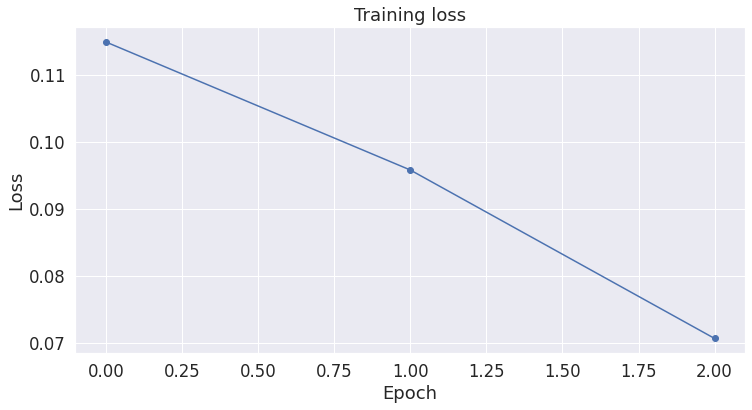

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [31]:
sum(validation_labels.numpy()==1)/len(validation_labels.numpy())
### that's why in the validation, accuracy is alway 0.65. It just predict all the labels to be score 5.

0.6521739130434783

Another important takeaway is that lr here should be larger than default. I use max_lr=9*10e-3 <br>
Another takeaway: try different shape of lrs, that's pretty influencial on the results.<br>
Try adjusting learning rate, the dropout probability(config.hidden_dropout_prob) and batch size (32 to 16) <br>
when seeing the lowest loss happens in the early stage of training, try to lower the lr and let it learn more slowly.
